In [1]:
%matplotlib inline
import utils; #reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

In [275]:
path = "data/ml-20m/"
#path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [276]:
ratings = pd.read_csv(path+'ratings.csv')
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

users = ratings.userId.unique()
movies = ratings.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()

np.random.seed = 42

msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [277]:
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
        self.losses = []
        
    def on_epoch_begin(self, epoch, logs={}):
        self.losses.append([])
        
    def on_batch_end(self, batch, logs={}):
        self.losses[-1].append(logs.get('loss'))

In [278]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [312]:
n_factors=50

In [313]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [314]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization(axis=1)(x)
x = Dropout(0.8)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [315]:
loss_history = LossHistory()

In [330]:
nn.optimizer.lr=0.001

In [339]:
batch_size = 32000
nb_epoch = 1
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=nb_epoch, 
        validation_data=([val.userId, val.movieId], val.rating),
        callbacks=[loss_history], verbose=1)

Train on 16002147 samples, validate on 3998116 samples
Epoch 1/1
16002147/16002147 [==============================] - 249s - loss: 0.7794 - val_loss: 0.7411

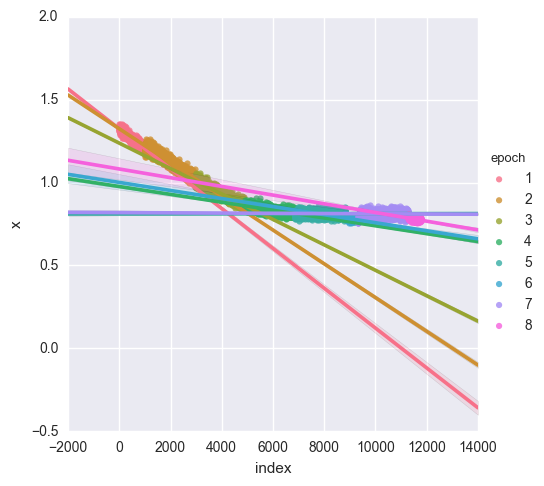

In [341]:
drop = 1
losses = [np.hstack(x) for x in loss_history.losses[drop:]]
ll = np.hstack(losses)
epoch = np.hstack([np.array([i+drop] * len(losses[i])) for i in range(len(losses))])
df = pd.DataFrame.from_dict({'x':ll, 'epoch': epoch})
df = df.reset_index()
sns.lmplot(y='x', x='index', hue='epoch', data=df)